In [47]:
import numpy as np
import pandas as pd
import os
from scipy import io
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pickle

import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("husl", 5)

In [ ]:
from torch.utils.data import DataLoader
import torch

In [140]:
def make_ev_data(look_back, horizon_length, stride, horizon_stride, label_index=3):
    path = '/workspace/Dataset/TSData/Electric_Vehicle_data/'
    
    dfs = []
    for i in range(1,6):
        file= 'route%d.mat'%i
        df = preprocess(path, file)
        dfs.append(df)
        
    # scaler fitting
    scaled_data, scaler = fit_scaler(dfs)
    
    train_X, train_y = [], []
    test_X, test_y = [], []
    
    for i, d in enumerate(scaled_data):
        if i== 0:
            test_X, test_y = dataToNumpy(d, look_back, horizon_length, stride, horizon_stride, label_index)
        else:
            tempX, tempy = dataToNumpy(d, look_back, horizon_length, stride, horizon_stride, label_index)
            if len(train_X) == 0:
                train_X, train_y = tempX, tempy
            else:
                train_X, train_y = np.concatenate((train_X, tempX)), np.concatenate((train_y, tempy))
    
    return (train_X, train_y), (test_X, test_y), scaler
        

def fit_scaler(data):    
    # normalization
    scaler = preprocessing.StandardScaler()
    
    d = None
    for i in range(5):
        if i == 0:
            d = data[i]
        else:
            d = pd.concat((d, data[i]))
    d = scaler.fit(d)
    
    scaled_data = []
    for i in range(5):
        scaled_data.append(scaler.transform(data[i]))
    
    return scaled_data, scaler
    

def preprocess(path, file):
    # preprocessing
    mat_file = io.loadmat(os.path.join(path, file))
    df_data = {}
    for key in mat_file.keys():
        if not "__" in key:
            df_data[key] = mat_file[key].squeeze()

    df = pd.DataFrame(df_data)
    df = df.ffill().bfill()
    df.index = df['Time']
    df = df.drop('Time', axis=1)
    label = df.columns.to_numpy()
    
    return df


def dataToNumpy(data, look_back, horizon_length, window_stride, horizon_stride, label_index=3):
    total_data_size = math.trunc((data.shape[0]-look_back-horizon_length+1)/window_stride)
#     print(total_data_size)
    features = np.zeros((total_data_size, int(look_back/window_stride), 5))
    labels = np.zeros((total_data_size, int(horizon_length/horizon_stride)))
    j=0
    while (j+look_back+horizon_length)<data.shape[0]:
        feature = np.array(data[j:(j+look_back)])
        label = np.array(data[(j+look_back):(j+look_back+horizon_length), label_index]).squeeze()
        label = label[::-1*horizon_stride]
        label = np.flip(label)
#         label = np.array(data[j+look_back+horizon_length, 3]).squeeze()
#         label = np.digitize(label, bins = np.array([0, 0.25, 0.5, 0.75]), right=True)
        features[int(j/window_stride)] = feature
        labels[int(j/window_stride)] = label
        j+=window_stride
    return features, labels

In [141]:
def get_loader(x, y, batch_size, shuffle=True, drop_last=True):
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    #     print(x.shape, y.shape)
    dataset = data.TensorDataset(x, y)
    loader = data.DataLoader(dataset, batch_size, shuffle=shuffle, drop_last=drop_last)
    return loader

In [148]:
# X, y, scaler = make_ev_data(100, 50, 1, label_index=3)
trainset, testset, scaler =  make_ev_data(100, 50, 1, 2, label_index=3)
tload = get_loader(trainset[0], trainset[1], 200)

In [149]:
trainset[0].shape

(132433, 100, 5)

In [151]:
X.transpose(2, 1).shape

torch.Size([200, 5, 100])

In [150]:
for X, y in tload:
    print(X.shape, y.shape)
    break

torch.Size([200, 100, 5]) torch.Size([200, 25])


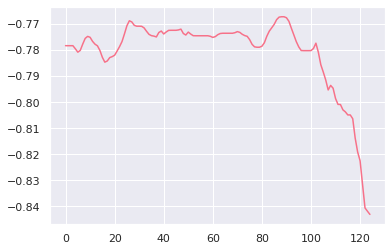

In [145]:
idx = 37

plt.plot(np.concatenate((X[idx,:,3].numpy(), y[idx].numpy())))

In [122]:
X[2,:,3], y[2]

(tensor([0.5140, 0.5170, 0.5188, 0.5190, 0.5194, 0.5204, 0.5224, 0.5251, 0.5283,
         0.5325, 0.5378, 0.5399, 0.5448, 0.5534, 0.5635, 0.5730, 0.5815, 0.5894,
         0.5977, 0.6078, 0.6182, 0.6269, 0.6327, 0.6356, 0.6396, 0.6478, 0.6570,
         0.6652, 0.6718, 0.6756, 0.6789, 0.6851, 0.6920, 0.6974, 0.6970, 0.6907,
         0.6825, 0.6748, 0.6674, 0.6604, 0.6526, 0.6408, 0.6275, 0.6211, 0.6189,
         0.6190, 0.6211, 0.6204, 0.6144, 0.6032, 0.5944, 0.5894, 0.5845, 0.5745,
         0.5642, 0.5540, 0.5433, 0.5377, 0.5407, 0.5496, 0.5548, 0.5594, 0.5675,
         0.5776, 0.5881, 0.5971, 0.6039, 0.6093, 0.6133, 0.6159, 0.6150, 0.6139,
         0.6149, 0.6147, 0.6109, 0.6035, 0.5944, 0.5855, 0.5762, 0.5679, 0.5618,
         0.5523, 0.5374, 0.5197, 0.5018, 0.4850, 0.4683, 0.4483, 0.4257, 0.4022,
         0.3809, 0.3596, 0.3365, 0.3120, 0.2900, 0.2699, 0.2520, 0.2362, 0.2213,
         0.2060]),
 tensor([0.3465, 0.3264, 0.3066, 0.2884, 0.2739, 0.2629, 0.2535, 0.2447, 0.2358,
         

In [72]:
all_s * 0.2

32796.8

In [4]:
df_data = {}
for key in mat_file.keys():
    if not "__" in key:
        df_data[key] = mat_file[key].squeeze()

df = pd.DataFrame(df_data)
df = df.ffill().bfill()
df.index = df['Time']
df = df.drop('Time', axis=1)

In [5]:
label = df.columns.to_numpy()

In [16]:
df['VOLTAGE']

Time
0.000000      -1.2
0.066667      -1.2
0.133333      -1.2
0.200000      -1.2
0.266667      -1.2
              ... 
2063.333333   -1.1
2063.400000   -1.1
2063.466667   -1.1
2063.533333   -1.1
2063.600000   -1.1
Name: CURRENT, Length: 30955, dtype: float64

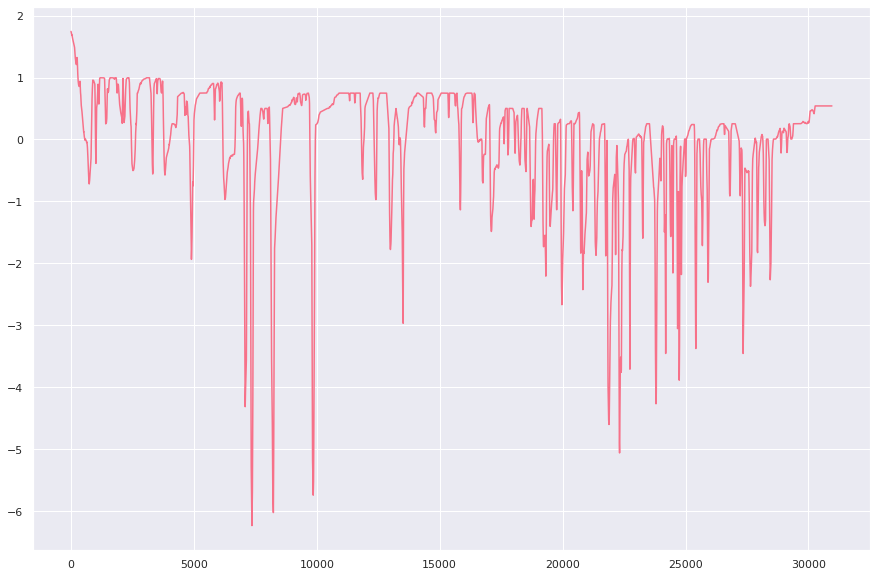

In [21]:
plt.figure(figsize=(15, 10))
plt.plot(data[:,-1])
# plt.legend(label)

In [13]:
data = scaler.fit_transform(df)

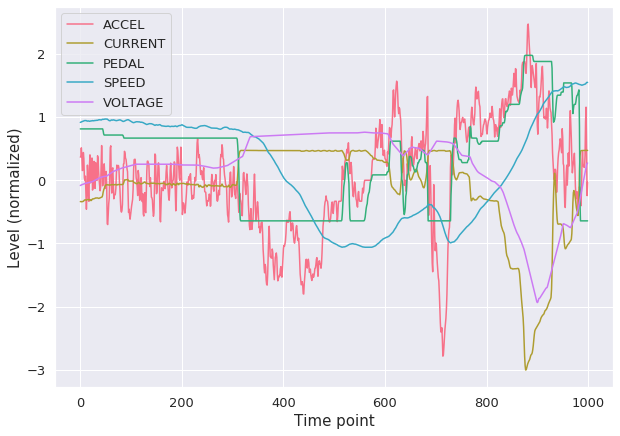

In [9]:
plt.figure(figsize=(10,7))
plt.xlabel('Time point', fontsize=15)
plt.ylabel('Level (normalized)', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.plot(data[4000:5000])
plt.legend(label, fontsize=13)

In [10]:
data.shape

(30955, 5)

In [34]:
def dataToNumpy(data, look_back, horizon_length, stride, label_index=3):
    total_data_size = math.trunc((data.shape[0]-look_back-horizon_length+1)/stride)
    print(total_data_size)
    features = np.zeros((total_data_size, look_back, 5))
    labels = np.zeros((total_data_size, horizon_length))
    j=0
    while (j+look_back+horizon_length)<data.shape[0]:
        feature = np.array(data[j:(j+look_back)])
        label = np.array(data[(j+look_back):(j+look_back+horizon_length), label_index]).squeeze()
#         label = label[::-20]
        label = np.flip(label)
#         label = np.array(data[j+look_back+horizon_length, 3]).squeeze()
#         label = np.digitize(label, bins = np.array([0, 0.25, 0.5, 0.75]), right=True)
        features[int(j/stride)] = feature
        labels[int(j/stride)] = label
        j+=stride
    return features, labels

In [38]:
a = dataToNumpy(data, 100, 50, 1)

30806


In [39]:
a[0].shape, a[1].shape

((30806, 100, 5), (30806, 50))